In [342]:
from sklearn.ensemble import  RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import seaborn as sns

import sys
sys.path.append("../bayseg/")
import bayseg

In [343]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
from classification_utilities import display_cm, display_adj_cm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import medfilt

In [344]:
#Load Data
data = pd.read_csv("../bayseg/data/2016-ml-contest-Hall/Nomalised_data.csv")

# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

# Store features and labels
X = data[feature_names].values 
y = data['Facies'].values 

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

# Fill 'PE' missing values with mean
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

In [345]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

X_aug, padded_rows = augment_features(X, well, depth)

In [346]:
# Initialize model selection methods
lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
    
        
def preprocess():
    
    # Preprocess data to use in model
    X_train_aux = []
    X_test_aux = []
    y_train_aux = []
    y_test_aux = []
    
    # For each data split
    split = split_list[5]
        
    # Remove padded rows
    split_train_no_pad = np.setdiff1d(split['train'], padded_rows)

    # Select training and validation data from current split
    X_tr = X_aug[split_train_no_pad, :]
    X_v = X_aug[split['val'], :]
    y_tr = y[split_train_no_pad]
    y_v = y[split['val']]

    # Select well labels for validation data
    well_v = well[split['val']]

    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
        
    X_train_aux.append( X_tr )
    X_test_aux.append( X_v )
    y_train_aux.append( y_tr )
    y_test_aux.append (  y_v )
    
    X_train = np.concatenate( X_train_aux )
    X_test = np.concatenate ( X_test_aux )
    y_train = np.concatenate ( y_train_aux )
    y_test = np.concatenate ( y_test_aux )
    
    return X_train , X_test , y_train , y_test

In [347]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = preprocess()

tpot = TPOTClassifier(generations=5, population_size=20, 
                      verbosity=2,max_eval_time_mins=20,
                      max_time_mins=100,scoring='f1_micro',
                      random_state = 17)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('FinalPipeline.py') 

C:\Users\CGRE-HiWi\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\CGRE-HiWi\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1 - Current best internal CV score: 0.7218305242872587


Generation 2 - Current best internal CV score: 0.7300345458158001


Generation 3 - Current best internal CV score: 0.7300345458158001


Generation 4 - Current best internal CV score: 0.7423646122500995


Generation 5 - Current best internal CV score: 0.7500588276598688


Generation 6 - Current best internal CV score: 0.7500588276598688


Generation 7 - Current best internal CV score: 0.7516465335421076


Generation 8 - Current best internal CV score: 0.759535838891402


Generation 9 - Current best internal CV score: 0.759535838891402



TPOT closed prematurely. Will use the current best pipeline.



Best pipeline: RandomForestClassifier(XGBClassifier(GaussianNB(input_matrix), learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100, nthread=1, subsample=0.75), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=5, min_samples_split=11, n_estimators=100)
0.767123287671


True

In [348]:
from sklearn.ensemble import  RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier

In [349]:
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_v, well_v):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    # Train classifier
    #clf = make_pipeline(make_union(VotingClassifier([("est", ExtraTreesClassifier(criterion="gini", max_features=1.0, n_estimators=500))]), FunctionTransformer(lambda X: X)), XGBClassifier(learning_rate=0.73, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.27))
    #clf =  make_pipeline( KNeighborsClassifier(n_neighbors=5, weights="distance") ) 
    #clf = make_pipeline(MaxAbsScaler(),make_union(VotingClassifier([("est", RandomForestClassifier(n_estimators=500))]), FunctionTransformer(lambda X: X)),ExtraTreesClassifier(criterion="entropy", max_features=0.0001, n_estimators=500))
    # * clf = make_pipeline( make_union(VotingClassifier([("est", BernoulliNB(alpha=60.0, binarize=0.26, fit_prior=True))]), FunctionTransformer(lambda X: X)),RandomForestClassifier(n_estimators=500))
    clf = make_pipeline ( XGBClassifier(learning_rate=0.12, max_depth=3, min_child_weight=10, n_estimators=150, seed = 17, colsample_bytree = 0.9) )
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

In [350]:
#Load testing data
test_data = pd.read_csv("../bayseg/data/2016-ml-contest-Hall/test_data_new.csv")

# Prepare training data
X_tr = X
y_tr = y

# Augment features
X_tr, padded_rows = augment_features(X_tr, well, depth)

# Removed padded rows
X_tr = np.delete(X_tr, padded_rows, axis=0)
y_tr = np.delete(y_tr, padded_rows, axis=0) 

# Prepare test data
well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values

# Augment features
X_ts, padded_rows = augment_features(X_ts, well_ts, depth_ts)

# Predict test labels
y_ts_hat = train_and_test(X_tr, y_tr, X_ts, well_ts)

# Save predicted labels
test_data['Facies'] = y_ts_hat
test_data.to_csv('Prediction_XX_Final.csv')

In [351]:
# predict_data = pd.read_csv("Prediction_XX_Final.csv")
# result = data[data["Well Name"] == "SHRIMPLIN"]["Facies"]
# print(predict_data["Facies"].values)   

In [322]:
# sol = np.repeat(np.expand_dims(predict_data["Facies"].values, 1), 100, 1)
# ml_sol = np.repeat(np.expand_dims(result, 1), 100, 1)

# fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(2,13))

# ax[0].imshow(sol, cmap="viridis")
# ax[1].imshow(ml_sol, cmap="viridis")

# np.count_nonzero(sol[:,1]-ml_sol[:,1])

# ax[0].grid(False)
# ax[1].grid(False)

In [232]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../bayseg")
import bayseg

In [233]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\CGRE-HiWi\Documents\bayseg


In [355]:
data = pd.read_csv("../bayseg/data/2016-ml-contest-Hall/Nomalised_data.csv")

In [129]:
def normalize_feature_vectors(feature_vectors):
    return (feature_vectors - np.mean(feature_vectors, axis=0).T) / np.std(feature_vectors, axis=0)

In [130]:
feature_names =  ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE']
feature_vectors = data[feature_names]

In [131]:
coords = np.array([data["Depth"].values]).T

In [132]:
feature_vectors_norm = normalize_feature_vectors(feature_vectors.values)

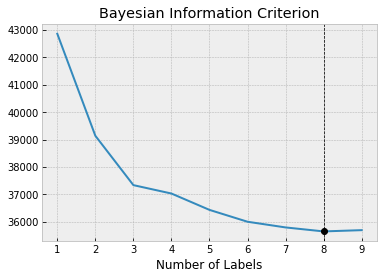

global minimum:  8


In [133]:
bayseg.bic(feature_vectors_norm, 9)

In [134]:
clf = bayseg.BaySeg(feature_vectors_norm, n_labels=25)

In [135]:
np.shape(data)

(3231, 23)

In [136]:
clf.fit(250, 
        beta_jump_length=2,  
        mu_jump_length=0.0005, 
        cov_volume_jump_length=0.00005, 
        theta_jump_length=0.0000005, verbose=False)

  1%|▋                                                                                 | 2/250 [00:04<08:17,  2.01s/it]C:\Users\CGRE-HiWi\Documents\bayseg\bayseg\bayseg.py:873: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(np.longfloat(log_target_prop - log_target_prev))
  2%|█▎                                                                                | 4/250 [00:08<08:12,  2.00s/it]


KeyboardInterrupt: 

In [352]:
predict_facie = pd.read_csv("Prediction_XX_Final.csv")["Facies"]

In [353]:
predict_facie.shape

(415,)

In [356]:
indeces = np.where(data["Well Name"] == "NOLAN")[0]
test_data = data[data["Well Name"] == "NOLAN"]

seg = clf.labels[-1][indeces]
seg.shape

(415,)

In [357]:
new_seg = np.zeros(shape = (len(seg),))
for i in range(0, len(seg)):
    if i == 0:
        new_seg[i] = 0
    elif seg[i] == seg[i-1]:
        new_seg[i] = new_seg[i-1]+0
    elif seg[i] != seg[i-1]:
        new_seg[i] = new_seg[i-1]+1 
new_seg

array([   0.,    0.,    0.,    1.,    1.,    1.,    2.,    3.,    4.,
          5.,    6.,    7.,    8.,    8.,    8.,    9.,    9.,    9.,
         10.,   10.,   10.,   10.,   11.,   11.,   12.,   13.,   13.,
         13.,   14.,   14.,   14.,   14.,   14.,   14.,   14.,   15.,
         16.,   16.,   17.,   18.,   19.,   19.,   19.,   20.,   20.,
         20.,   20.,   21.,   22.,   23.,   23.,   24.,   25.,   25.,
         25.,   25.,   26.,   27.,   28.,   29.,   29.,   30.,   30.,
         30.,   30.,   30.,   30.,   31.,   31.,   32.,   33.,   33.,
         34.,   34.,   35.,   35.,   36.,   37.,   38.,   38.,   38.,
         38.,   38.,   39.,   39.,   39.,   39.,   40.,   40.,   41.,
         42.,   43.,   44.,   45.,   45.,   45.,   45.,   46.,   47.,
         48.,   48.,   49.,   49.,   49.,   50.,   51.,   51.,   52.,
         52.,   52.,   52.,   53.,   54.,   54.,   54.,   55.,   55.,
         56.,   57.,   57.,   57.,   58.,   58.,   58.,   58.,   58.,
         58.,   58.,

In [358]:
compare = np.vstack((predict_facie, new_seg))

In [359]:

compare

array([[   3.,    3.,    3.,    3.,    3.,    3.,    3.,    3.,    3.,
           3.,    3.,    3.,    3.,    3.,    3.,    2.,    2.,    2.,
           2.,    2.,    1.,    1.,    1.,    1.,    1.,    2.,    2.,
           2.,    2.,    2.,    2.,    2.,    1.,    1.,    1.,    1.,
           1.,    1.,    3.,    3.,    3.,    3.,    3.,    3.,    5.,
           5.,    5.,    8.,    8.,    8.,    8.,    6.,    6.,    6.,
           5.,    5.,    5.,    5.,    5.,    5.,    5.,    6.,    6.,
           7.,    7.,    7.,    7.,    9.,    9.,    9.,    8.,    6.,
           6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,
           7.,    8.,    8.,    8.,    8.,    7.,    7.,    7.,    8.,
           8.,    8.,    8.,    7.,    6.,    6.,    6.,    6.,    6.,
           6.,    6.,    6.,    6.,    4.,    3.,    3.,    3.,    3.,
           3.,    3.,    3.,    3.,    3.,    3.,    3.,    3.,    3.,
           3.,    3.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
      

In [360]:
L = np.zeros(shape=(len(np.unique(new_seg)),))
segs = np.unique(new_seg)
pack  = [np.where(new_seg==segs[i]) for i in range(len(segs))]
predict_pack = [compare[0][pack[i]] for i in range(len(segs))]
predict_pack

[array([ 3.,  3.,  3.]),
 array([ 3.,  3.,  3.]),
 array([ 3.]),
 array([ 3.]),
 array([ 3.]),
 array([ 3.]),
 array([ 3.]),
 array([ 3.]),
 array([ 3.,  3.,  3.]),
 array([ 2.,  2.,  2.]),
 array([ 2.,  2.,  1.,  1.]),
 array([ 1.,  1.]),
 array([ 1.]),
 array([ 2.,  2.,  2.]),
 array([ 2.,  2.,  2.,  2.,  1.,  1.,  1.]),
 array([ 1.]),
 array([ 1.,  1.]),
 array([ 3.]),
 array([ 3.]),
 array([ 3.,  3.,  3.]),
 array([ 3.,  5.,  5.,  5.]),
 array([ 8.]),
 array([ 8.]),
 array([ 8.,  8.]),
 array([ 6.]),
 array([ 6.,  6.,  5.,  5.]),
 array([ 5.]),
 array([ 5.]),
 array([ 5.]),
 array([ 5.,  5.]),
 array([ 6.,  6.,  7.,  7.,  7.,  7.]),
 array([ 9.,  9.]),
 array([ 9.]),
 array([ 8.,  6.]),
 array([ 6.,  6.]),
 array([ 6.,  6.]),
 array([ 6.]),
 array([ 6.]),
 array([ 6.,  6.,  6.,  7.,  8.]),
 array([ 8.,  8.,  8.,  7.]),
 array([ 7.,  7.]),
 array([ 8.]),
 array([ 8.]),
 array([ 8.]),
 array([ 8.]),
 array([ 7.,  6.,  6.,  6.]),
 array([ 6.]),
 array([ 6.]),
 array([ 6.,  6.]),
 arra

In [361]:
import math
def normpdf(x, mean, sd):
    var = sd**2
    pi = 3.1415926
    denom = (2*pi*var)**.5
    num = np.exp((-x-mean)**2/(2*var))
    return num/denom

In [362]:
from scipy.stats import norm
L = np.zeros(shape = (len(predict_pack),))
for i in range(len(predict_pack)):
    n = predict_pack[i]
    if len(np.unique(n))!= 1:
        L[i]=np.argmax(np.bincount(np.int_(n)))
        print(L[i])
    else:
        L[i] = predict_pack[i][0]
    
print(L)      

1.0
2.0
5.0
5.0
7.0
6.0
6.0
8.0
6.0
6.0
2.0
2.0
1.0
3.0
3.0
2.0
8.0
2.0
2.0
2.0
8.0
3.0
8.0
8.0
5.0
3.0
2.0
2.0
8.0
5.0
6.0
[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  1.  1.  1.  2.  2.  1.  1.  3.
  3.  3.  5.  8.  8.  8.  6.  5.  5.  5.  5.  5.  7.  9.  9.  6.  6.  6.
  6.  6.  6.  8.  7.  8.  8.  8.  8.  6.  6.  6.  6.  6.  3.  3.  3.  3.
  3.  3.  3.  2.  2.  1.  3.  8.  8.  8.  8.  8.  4.  4.  6.  6.  3.  2.
  3.  3.  3.  2.  2.  2.  3.  8.  8.  8.  8.  8.  6.  6.  6.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  8.  8.  8.  2.  2.  2.  2.  2.
  2.  2.  3.  3.  3.  3.  8.  8.  5.  5.  5.  4.  3.  3.  3.  8.  7.  5.
  5.  5.  6.  7.  7.  7.  7.  3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  2.
  2.  2.  8.  5.  5.  5.  6.  5.  5.  5.  5.  5.  5.  6.  8.  8.  5.  5.
  5.  5.  5.]


In [363]:
def litho(L, label):
    count = 0
    new = np.zeros(shape=(len(label),))
    for i in range(0, len(label)-1):
        if i == 0:
            new[i] = L[count]
        elif label[i] == label[i-1]:
            new[i] = L[count]
        elif label[i] != label[i-1]:
            count = count+1
            new[i] = L[count]            
    new[-1] = L[-1] 
    return new

In [364]:
new = litho(L, new_seg)
print(new)
print(predict_facie.values)

[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  2.
  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.
  1.  1.  3.  3.  3.  3.  3.  5.  5.  5.  5.  8.  8.  8.  8.  6.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  7.  7.  7.  7.  7.  7.  9.  9.  9.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  8.  8.  8.  8.  7.  7.  8.
  8.  8.  8.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  1.  1.  3.  3.  3.  3.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  4.  4.  4.  4.  6.  6.  6.  3.  3.  3.  3.  3.  2.
  2.  3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  2.  2.  2.  2.  3.  3.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  6.
  6.  6.  6.  6.  6.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  2.  2.  2

In [365]:
predict_facie = pd.read_csv("Prediction_XX_Final.csv")["Facies"]
test_data = pd.read_csv("../bayseg/data/2016-ml-contest-Hall/test_data_new.csv")

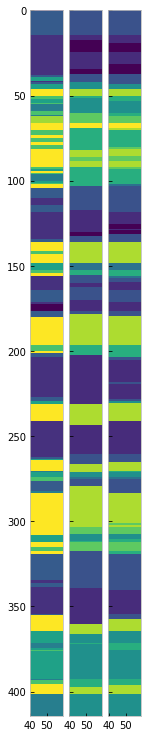

In [366]:
sol = np.repeat(np.expand_dims(test_data["Facies"].values, 1), 100, 1)
ml_sol = np.repeat(np.expand_dims(new, 1), 100, 1)
contest = np.repeat(np.expand_dims(predict_facie, 1), 100, 1)

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(2,13))

ax[0].imshow(sol, cmap="viridis")
ax[1].imshow(ml_sol, cmap="viridis")
ax[2].imshow(contest, cmap="viridis")


ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

In [340]:
test_data["Facies"].values

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 6, 6, 4, 6, 6, 8, 8, 8,
       6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 6, 8, 8, 8, 8, 6, 6, 5, 6, 6, 6, 6, 6,
       3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2, 2, 2, 2, 2, 2, 3, 4, 5, 6, 6, 6,
       6, 6, 6, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 5, 5, 5, 5, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1,

In [341]:
print(np.count_nonzero(sol[:,1]-ml_sol[:,1])/len(test_data))
print(np.count_nonzero(sol[:,1]-contest[:,1])/len(test_data))


0.3972055888223553
0.3772455089820359


In [ ]:
 data[data["Well Name"] == "CHURCHMAN BIBLE"]
    np.where(data["Well Name"] == "CHURCHMAN BIBLE")